# Convolutional Variational Autoencoder

## Setup

In [1]:
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

2022-07-05 00:06:08.684330: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load the MNIST dataset

In [2]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [3]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [4]:
train_size = 60000
batch_size = 32
test_size = 10000

In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

2022-07-05 00:06:15.200272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-05 00:06:15.790398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14254 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b2:00.0, compute capability: 8.6


## Define the encoder and decoder networks


In [6]:
class betaVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(betaVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [7]:
beta = 10

## Define the loss function and the optimizer
原来是
$$\log p(x| z) + \log p(z) - \log q(z|x),$$
现在
$$\log p(x| z) + \beta [ \log p(z) - \log q(z|x) ],$$

where $z$ is sampled from $q(z|x)$, $x$ is sampled from $p(x)$.  


In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-0.5 * ((sample - mean)**2*tf.exp(-logvar)+logvar+log2pi), axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + beta*logpz - beta*logqz_x)

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

## Training

In [9]:
epochs = 10

latent_dim = 2
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = betaVAE(latent_dim)

In [10]:
def generate_and_save_images(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.suptitle('Epoch %d'%epoch)
    plt.savefig('plots/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [11]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 9, Test set ELBO: -191.24969482421875, time elapse for current epoch: 10.740044355392456


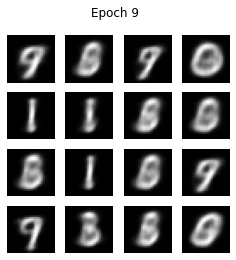

In [12]:
for epoch in range(epochs):
    start_time = time.time()
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    end_time = time.time()

    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
    
    generate_and_save_images(model, epoch, test_sample)

### Display a generated image from the last training epoch

In [13]:
def display_image(epoch_no):
    return PIL.Image.open('plots/image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

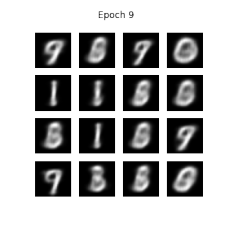

In [14]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

### Display an animated GIF of all the saved images

In [15]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('plots/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

/tmp/ipykernel_4095426/1885124440.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_4095426/1885124440.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



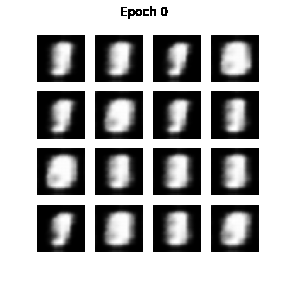

In [16]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

### Display a 2D manifold of digits from the latent space

Running the code below will show a continuous distribution of the different digit classes, with each digit morphing into another across the 2D latent space. Use [TensorFlow Probability](https://www.tensorflow.org/probability) to generate a standard normal distribution for the latent space.

In [17]:
def plot_latent_images(model, n, digit_size=28):

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

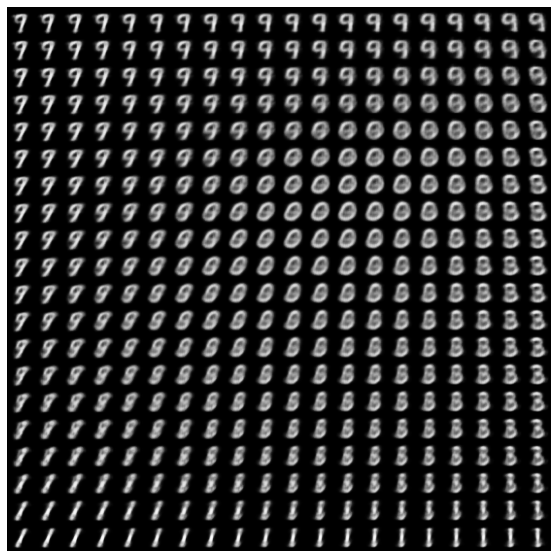

In [18]:
plot_latent_images(model, 20)